<a href="https://colab.research.google.com/github/israelgonzalezb/neuromatch-dl/blob/main/tutorials/W2D1_Regularization/student/W2D1_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 1: Regularization techniques part 1

**Week 2, Day 1: Regularization**

**By Neuromatch Academy**

__Content creators:__ Ravi Teja Konkimalla, Mohitrajhu Lingan Kumaraian, Kevin Machado Gamboa, Kelson Shilling-Scrivo, Lyle Ungar

__Content reviewers:__ Piyush Chauhan, Siwei Bai, Kelson Shilling-Scrivo

__Content editors:__ Roberto Guidotti, Spiros Chavlis

__Production editors:__ Saeed Salehi, Gagana B, Spiros Chavlis

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Tutorial Objectives

1. Big Artificial Neural Networks (ANNs) are efficient universal approximators due to their adaptive basis functions
2. ANNs memorize some but generalize well
3. Regularization as shrinkage of overparameterized models: early stopping 

In [ ]:
# @title Tutorial slides

from IPython.display import IFrame
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/mf79a/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

These are the slides for all videos in this tutorial. If you want to locally download the slides, click [here](https://osf.io/mf79a/download).

---
# Setup
Note that some of the code for today can take up to an hour to run. We have therefore "hidden" the code and shown the resulting outputs.


In [1]:
# @title Install dependencies

# @markdown **WARNING**: There may be *errors* and/or *warnings* reported during the installation. However, they should be ignored.

!pip install imageio --quiet
!pip install imageio-ffmpeg --quiet
!pip install git+https://github.com/NeuromatchAcademy/evaltools --quiet

from evaltools.airtable import AirtableForm
atform = AirtableForm('appn7VdPRseSoMXEG', 'W2D1_T1','https://portal.neuromatchacademy.org/api/redirect/to/9c55f6cb-cdf9-4429-ac1c-ec44fe64c303')

     |████████████████████████████████| 26.9 MB 97.8 MB/s 


In [4]:
# Imports
import time
import copy
import torch
import pathlib

import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from tqdm.auto import tqdm
from IPython.display import HTML
from torchvision import transforms
from torchvision.datasets import ImageFolder

In [5]:
# @title Figure Settings
import ipywidgets as widgets
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [6]:
# @title Loading Animal Faces data
import requests, os
from zipfile import ZipFile

print("Start downloading and unzipping `AnimalFaces` dataset...")
name = 'afhq'
fname = f"{name}.zip"
url = f"https://osf.io/kgfvj/download"

if not os.path.exists(fname):
  r = requests.get(url, allow_redirects=True)
  with open(fname, 'wb') as fh:
    fh.write(r.content)

  if os.path.exists(fname):
    with ZipFile(fname, 'r') as zfile:
      zfile.extractall(f".")
      os.remove(fname)

print("Download completed.")

Start downloading and unzipping `AnimalFaces` dataset...
Download completed.


In [7]:
# @title Loading Animal Faces Randomized data

print("Start downloading and unzipping `Randomized AnimalFaces` dataset...")

names = ['afhq_random_32x32', 'afhq_10_32x32']
urls = ["https://osf.io/9sj7p/download",
        "https://osf.io/wvgkq/download"]


for i, name in enumerate(names):
  url = urls[i]
  fname = f"{name}.zip"

  if not os.path.exists(fname):
    r = requests.get(url, allow_redirects=True)
    with open(fname, 'wb') as fh:
      fh.write(r.content)

    if os.path.exists(fname):
      with ZipFile(fname, 'r') as zfile:
        zfile.extractall(f".")
        os.remove(fname)

print("Download completed.")

Start downloading and unzipping `Randomized AnimalFaces` dataset...
Download completed.


In [8]:
# @title Plotting functions
def imshow(img):
  """
  Display unnormalized image

  Args:
    img: np.ndarray
      Datapoint to visualize

  Returns:
    Nothing
  """
  img = img / 2 + 0.5     # Unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.axis(False)
  plt.show()


def plot_weights(norm, labels, ws,
                 title='Weight Size Measurement'):
  """
  Plot of weight size measurement [norm value vs layer]

  Args:
    norm: float
      Norm values
    labels: list
      Targets
    ws: list
      Weights
    title: string
      Title of plot

  Returns:
    Nothing
  """
  plt.figure(figsize=[8, 6])
  plt.title(title)
  plt.ylabel('Frobenius Norm Value')
  plt.xlabel('Model Layers')
  plt.bar(labels, ws)
  plt.axhline(y=norm,
              linewidth=1,
              color='r',
              ls='--',
              label='Total Model F-Norm')
  plt.legend()
  plt.show()


def early_stop_plot(train_acc_earlystop,
                    val_acc_earlystop, best_epoch):
  """
  Plot of early stopping

  Args:
    train_acc_earlystop: np.ndarray
      Training accuracy log until early stop point
    val_acc_earlystop: np.ndarray
      Val accuracy log until early stop point
    best_epoch: int
      Epoch at which early stopping occurs

  Returns:
    Nothing
  """
  plt.figure(figsize=(8, 6))
  plt.plot(val_acc_earlystop,label='Val - Early',c='red',ls = 'dashed')
  plt.plot(train_acc_earlystop,label='Train - Early',c='red',ls = 'solid')
  plt.axvline(x=best_epoch, c='green', ls='dashed',
              label='Epoch for Max Val Accuracy')
  plt.title('Early Stopping')
  plt.ylabel('Accuracy (%)')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()

In [9]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [10]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [11]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


---
# Section 0: Defining useful functions
Let's start the tutorial by defining some functions which we will use frequently today, such as: `AnimalNet`, `train`, `test` and `main`.

In [12]:
class AnimalNet(nn.Module):
  """
  Network Class - Animal Faces
  """

  def __init__(self):
    """
    Initialize parameters of AnimalNet

    Args:
      None

    Returns:
      Nothing
    """
    super(AnimalNet, self).__init__()
    self.fc1 = nn.Linear(3 * 32 * 32, 128)
    self.fc2 = nn.Linear(128, 32)
    self.fc3 = nn.Linear(32, 3)

  def forward(self, x):
    """
    Forward Pass of AnimalNet

    Args:
      x: torch.tensor
        Input features

    Returns:
      output: torch.tensor
        Outputs/Predictions
    """
    x = x.view(x.shape[0],-1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    output = F.log_softmax(x, dim=1)
    return output

The train function takes in the current model, along with the train_loader and loss function, and updates the parameters for a single pass of the entire dataset. The test function takes in the current model after every epoch and calculates the accuracy on the test dataset.

In [13]:
def train(args, model, train_loader, optimizer,
          reg_function1=None, reg_function2=None, criterion=F.nll_loss):
  """
  Trains the current input model using the data
  from Train_loader and Updates parameters for a single pass

  Args:
    args: dictionary
      Dictionary with epochs: 200, lr: 5e-3, momentum: 0.9, device: DEVICE
    model: nn.module
      Neural network instance
    train_loader: torch.loader
      Input dataset
    optimizer: function
      Optimizer
    reg_function1: function
      Regularisation function [default: None]
    reg_function2: function
      Regularisation function [default: None]
    criterion: function
      Specifies loss function [default: nll_loss]

  Returns:
    model: nn.module
      Neural network instance post training
  """
  device = args['device']
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    if reg_function1 is None:
      loss = criterion(output, target)
    elif reg_function2 is None:
      loss = criterion(output, target)+args['lambda']*reg_function1(model)
    else:
      loss = criterion(output, target) + args['lambda1']*reg_function1(model) + args['lambda2']*reg_function2(model)
    loss.backward()
    optimizer.step()

  return model


def test(model, test_loader, criterion=F.nll_loss, device='cpu'):
  """
  Tests the current model

  Args:
    model: nn.module
      Neural network instance
    device: string
      GPU/CUDA if available, CPU otherwise
    test_loader: torch.loader
      Test dataset
    criterion: function
      Specifies loss function [default: nll_loss]

  Returns:
    test_loss: float
      Test loss
  """
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += criterion(output, target, reduction='sum').item()  # Sum up batch loss
      pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  return 100. * correct / len(test_loader.dataset)


def main(args, model, train_loader, val_loader,
         reg_function1=None, reg_function2=None):
  """
  Trains the model with train_loader and
  tests the learned model using val_loader

  Args:
    args: dictionary
      Dictionary with epochs: 200, lr: 5e-3, momentum: 0.9, device: DEVICE
    model: nn.module
      Neural network instance
    train_loader: torch.loader
      Train dataset
    val_loader: torch.loader
      Validation set
    reg_function1: function
      Regularisation function [default: None]
    reg_function2: function
      Regularisation function [default: None]

  Returns:
    val_acc_list: list
      Log of validation accuracy
    train_acc_list: list
      Log of training accuracy
    param_norm_list: list
      Log of frobenius norm
    trained_model: nn.module
      Trained model/model post training
  """

  device = args['device']

  model = model.to(device)
  optimizer = optim.SGD(model.parameters(), lr=args['lr'],
                        momentum=args['momentum'])

  val_acc_list, train_acc_list,param_norm_list = [], [], []
  for epoch in tqdm(range(args['epochs'])):
    trained_model = train(args, model, train_loader, optimizer,
                          reg_function1=reg_function1,
                          reg_function2=reg_function2)
    train_acc = test(trained_model, train_loader, device=device)
    val_acc = test(trained_model, val_loader, device=device)
    param_norm = calculate_frobenius_norm(trained_model)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    param_norm_list.append(param_norm)

  return val_acc_list, train_acc_list, param_norm_list, trained_model

---
# Section 1: Regularization is Shrinkage

*Time estimate: ~20 mins*

In [ ]:
# @title Video 1: Introduction to Regularization
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1mo4y1X76E", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"jhQAnIHTR6A", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# Add event to airtable
atform.add_event('Video 1: Introduction to Regularization')

display(out)

A key idea of neural nets is that they use models that are "too complex" - complex enough to fit all the noise in the data. One then needs to "regularize" them to make the models fit complex enough, but not too complex. The more complex the model, the better it fits the training data, but if it is too complex, it generalizes less well; it memorizes the training data but is less accurate on future test data.

In [ ]:
# @title Video 2: Regularization as Shrinkage
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1YL411H7Dv", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"mhVbJ74upnQ", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# Add event to airtable
atform.add_event('Video 2: Regularization as Shrinkage')

display(out)

One way to think about Regularization is to think in terms of the magnitude of the overall weights of the model. A model with big weights can fit more data perfectly, whereas a model with smaller weights tends to underperform on the train set but can surprisingly do very well on the test set. Having the weights too small can also be an issue as it can then underfit the model.

In these tutorials, we use the sum of the Frobenius norm of all the tensors in the model as a measure of the "size of the model".

## Coding Exercise 1: Frobenius Norm

Before we start, let's define the Frobenius norm, sometimes also called the Euclidean norm of an $m×n$ matrix $A$  as the square root of the sum of the absolute squares of its elements.

<br>

\begin{equation}
  ||A||_F= \sqrt{\sum_{i=1}^m\sum_{j=1}^n|a_{ij}|^2}
\end{equation} 

<br>

This is just a measure of how big the matrix is, analogous to how big a vector is.

**Hint:** Use the functions `model.parameters()` or `model.named_parameters()`

In [17]:
def calculate_frobenius_norm(model):
  """
  Function to calculate frobenius norm

  Args:
    model: nn.module
      Neural network instance

  Returns:
    norm: float
      Frobenius norm
  """
  ####################################################################
  # Fill in all missing code below (...),
  # then remove or comment the line below to test your function
  # raise NotImplementedError("Define `calculate_frobenius_norm` function")
  ####################################################################
  norm = 0.0
  # Sum the square of all parameters
  for param in model.parameters():
    norm += torch.sum(torch.square(param))

  # Take a square root of the sum of squares of all the parameters
  norm = torch.sqrt(norm)
  return norm


# Add event to airtable
atform.add_event('Coding Exercise 1: Frobenius Norm')

# Seed added for reproducibility
set_seed(seed=SEED)

## uncomment below to test your code
net = nn.Linear(10, 1)
print(f'Frobenius norm of Single Linear Layer: {calculate_frobenius_norm(net)}')

Random seed 2021 has been set.
Frobenius norm of Single Linear Layer: 0.6572162508964539


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W2D1_Regularization/solutions/W2D1_Tutorial1_Solution_464cdd08.py)



```
Random seed 2021 has been set.
Frobenius Norm of Single Linear Layer: 0.6572162508964539
```

Apart from calculating the weight size for an entire model, we could also determine the weight size in every layer. For this, we can modify our `calculate_frobenius_norm` function as shown below. 

**Have a look how it works!!**

Random seed 2021 has been set.
Frobenius norm of Single Linear Layer: 0.6572


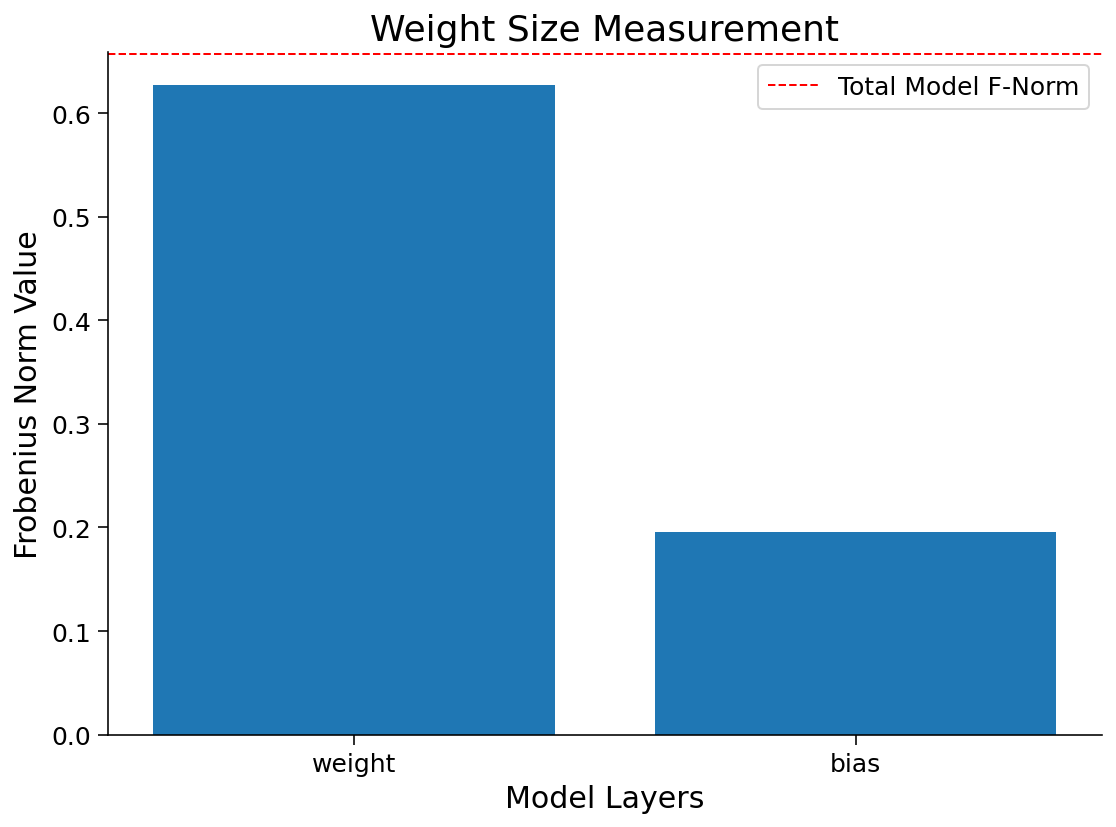

In [18]:
def calculate_frobenius_norm(model):
  """
  Calculate Frobenius Norm per Layer

  Args:
    model: nn.module
      Neural network instance

  Returns:
    norm: float
      Norm value
    labels: list
      Targets
    ws: list
      Weights
  """

  # Initialization of variables
  norm, ws, labels = 0.0, [], []

  # Sum all the parameters
  for name, parameters in model.named_parameters():
    p = torch.sum(parameters**2)
    norm += p

    ws.append((p**0.5).cpu().detach().numpy())
    labels.append(name)

  # Take a square root of the sum of squares of all the parameters
  norm = (norm**0.5).cpu().detach().numpy()

  return norm, ws, labels


set_seed(SEED)
net = nn.Linear(10,1)
norm, ws, labels = calculate_frobenius_norm(net)
print(f'Frobenius norm of Single Linear Layer: {norm:.4f}')
# Plots the weights
plot_weights(norm, labels, ws)

Using the last function, `calculate_frobenius_norm`, we can also obtain the Frobenius norm per layer for a whole ANN model and use the `plot_weigts` function to visualize them.

Random seed 2021 has been set.
Frobenius norm of Models weights: 7.3810


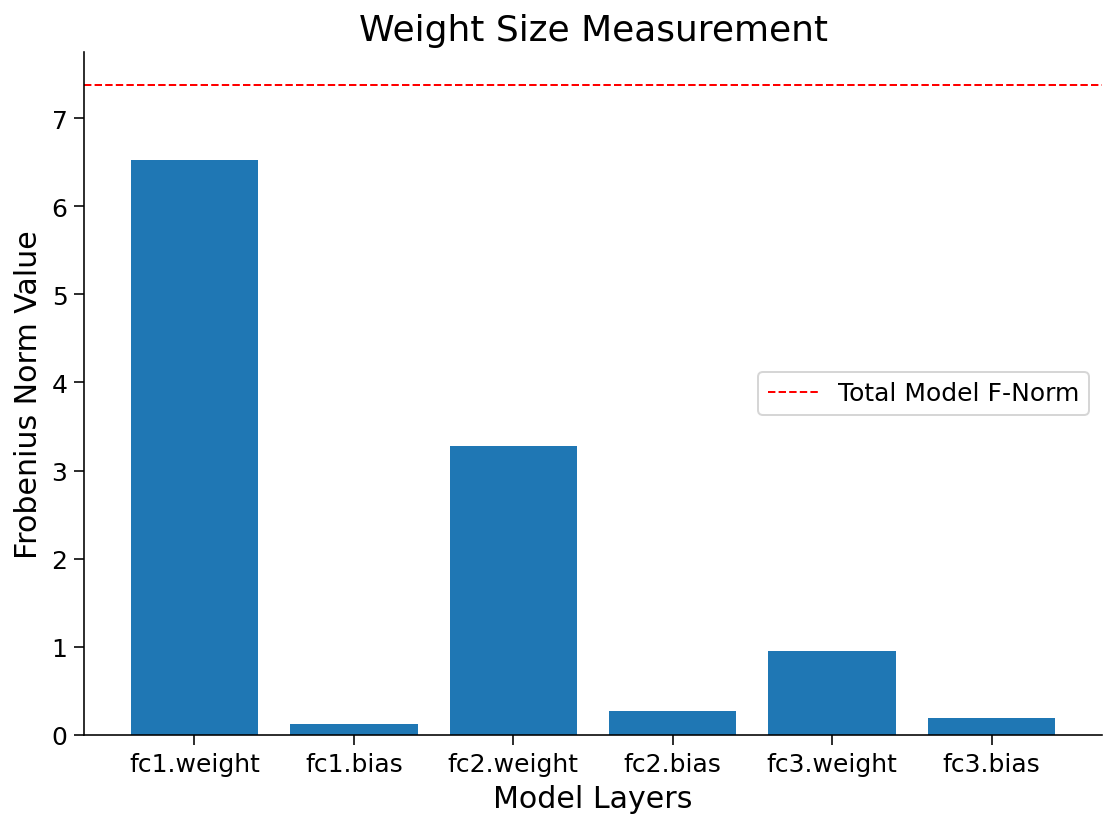

In [19]:
set_seed(seed=SEED)

# Creates a new model
model = AnimalNet()

# Calculates the forbenius norm per layer
norm, ws, labels = calculate_frobenius_norm(model)
print(f'Frobenius norm of Models weights: {norm:.4f}')

# Plots the weights
plot_weights(norm, labels, ws)

---
# Section 2: Overfitting

*Time estimate: ~15 mins*


In [ ]:
# @title Video 3: Overparameterization and Overfitting
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1NX4y1A73i", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"-HJ_9HxY38g", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# Add event to airtable
atform.add_event('Video 3: Overparameterization and Overfitting')

display(out)

## Section 2.1: Visualizing Overfitting

Let's create some synthetic dataset that we will use to illustrate overfitting in neural networks.

Random seed 2021 has been set.


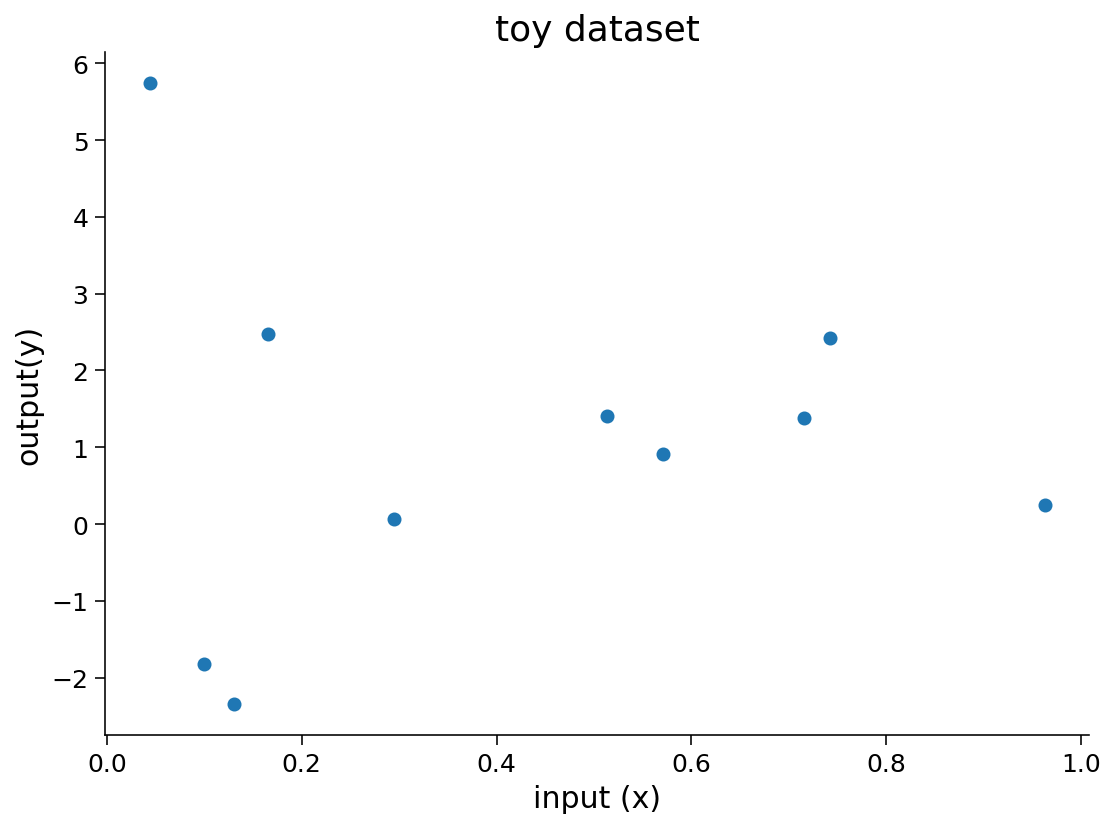

In [20]:
set_seed(seed=SEED)

# Creating train data
# Input
X = torch.rand((10, 1))
# Output
Y = 2*X + 2*torch.empty((X.shape[0], 1)).normal_(mean=0, std=1)  # Adding small error in the data

# Visualizing train data
plt.figure(figsize=(8, 6))
plt.scatter(X.numpy(),Y.numpy())
plt.xlabel('input (x)')
plt.ylabel('output(y)')
plt.title('toy dataset')
plt.show()

# Creating test dataset
X_test = torch.linspace(0, 1, 40)
X_test = X_test.reshape((40, 1, 1))

Let's create an overparametrized Neural Network that can fit on the dataset that we just created and train it. 

First, let's build the model architecture:

In [21]:
class Net(nn.Module):
  """
  Network Class - 2D with following structure
  nn.Linear(1, 300) + leaky_relu(self.fc1(x)) # First fully connected layer
  nn.Linear(300, 500) + leaky_relu(self.fc2(x)) # Second fully connected layer
  nn.Linear(500, 1) # Final fully connected layer
  """

  def __init__(self):
    """
    Initialize parameters of Net

    Args:
      None

    Returns:
      Nothing
    """
    super(Net, self).__init__()

    self.fc1 = nn.Linear(1, 300)
    self.fc2 = nn.Linear(300, 500)
    self.fc3 = nn.Linear(500, 1)

  def forward(self, x):
    """
    Forward pass of Net

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Output/Predictions
    """
    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x))
    output = self.fc3(x)
    return output

Next, let's define the different parameters for training our model:


In [22]:
set_seed(seed=SEED)

# Train the network on toy dataset
model = Net()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

iters = 0
# Calculates frobenius before training
normi, wsi, label = calculate_frobenius_norm(model)

Random seed 2021 has been set.


At this point, we can now train our model.

In [23]:
set_seed(seed=SEED)

# Initializing variables
# Losses
train_loss = []
test_loss = []

# Model norm
model_norm = []

# Initializing variables to store weights
norm_per_layer = []

max_epochs = 10000

running_predictions = np.empty((40, int(max_epochs / 500 + 1)))

for epoch in tqdm(range(max_epochs)):
  # Frobenius norm per epoch
  norm, pl, layer_names = calculate_frobenius_norm(model)

  # Training
  model_norm.append(norm)
  norm_per_layer.append(pl)
  model.train()
  optimizer.zero_grad()
  predictions = model(X)
  loss = criterion(predictions, Y)
  loss.backward()
  optimizer.step()

  train_loss.append(loss.data)
  model.eval()
  Y_test = model(X_test)
  loss = criterion(Y_test, 2*X_test)
  test_loss.append(loss.data)

  if (epoch % 500 == 0 or epoch == max_epochs - 1):
    running_predictions[:, iters] = Y_test[:, 0, 0].detach().numpy()
    iters += 1

Random seed 2021 has been set.


  0%|          | 0/10000 [00:00<?, ?it/s]

Now that we have finished training, let's see how the model has evolved over the training process.

In [24]:
# @title Animation (Run Me!)

set_seed(seed=SEED)
# Create a figure and axes
fig = plt.figure(figsize=(14, 5))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
# Organizing subplots
plot1, = ax1.plot([],[])
plot2 = ax2.bar([], [])


def frame(i):
  """
  Load animation frame

  Args:
    i: int
      Epoch number

  Returns:
    plot1: function
      Subplot of test-data vs running predictions
    plot2: function
      Subplot of test-data vs running predictions
  """
  ax1.clear()
  title1 = ax1.set_title('')
  ax1.set_xlabel("Input(x)")
  ax1.set_ylabel("Output(y)")

  ax2.clear()
  ax2.set_xlabel('Layer names')
  ax2.set_ylabel('Frobenius norm')
  title2 = ax2.set_title('Weight Measurement: Forbenius Norm')

  ax1.scatter(X.numpy(),Y.numpy())
  plot1 = ax1.plot(X_test[:,0,:].detach().numpy(),
                   running_predictions[:,i])
  title1.set_text(f'Epochs: {i * 500}')
  plot2 = ax2.bar(label, norm_per_layer[i*500])
  plt.axhline(y=model_norm[i*500], linewidth=1,
              color='r', ls='--',
              label=f'Norm: {model_norm[i*500]:.2f}')
  plt.legend()

  return plot1, plot2


anim = animation.FuncAnimation(fig, frame, frames=range(20),
                               blit=False, repeat=False,
                               repeat_delay=10000)
html_anim = HTML(anim.to_html5_video())
plt.close()

import IPython
IPython.display.display(html_anim)

Random seed 2021 has been set.


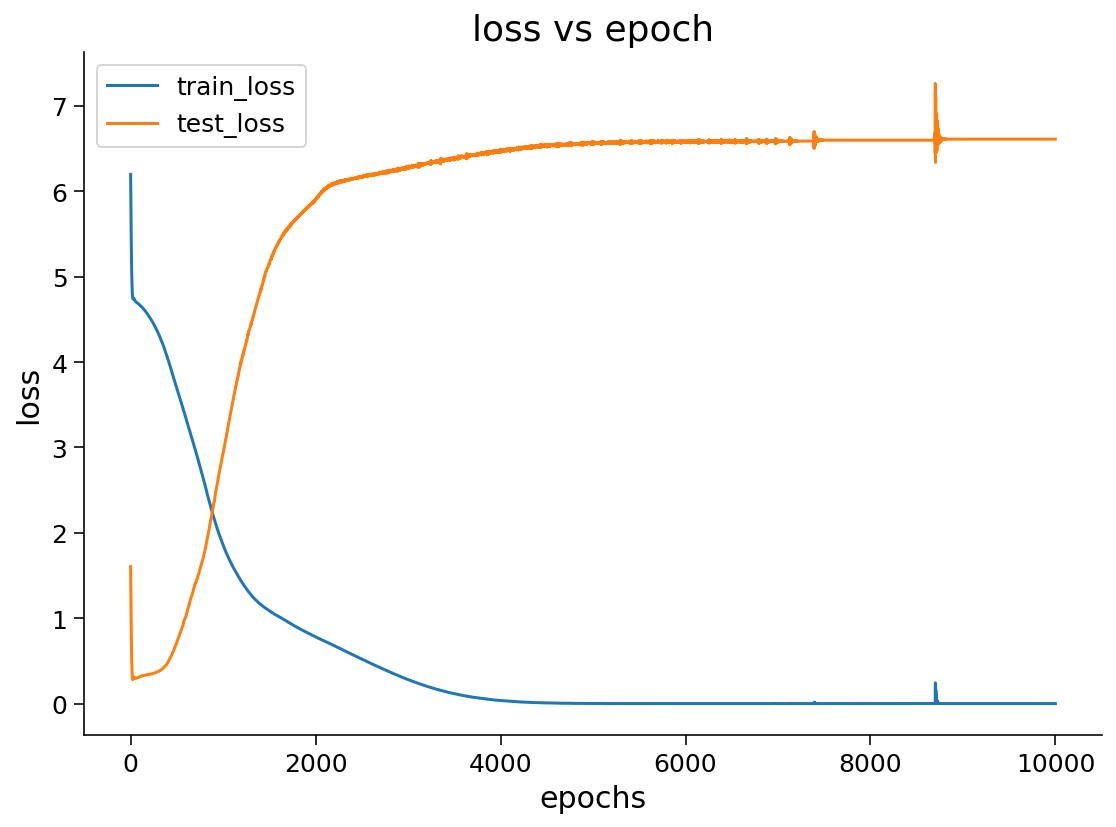

In [25]:
# @title Plot the train and test losses
plt.figure(figsize=(8, 6))
plt.plot(train_loss,label='train_loss')
plt.plot(test_loss,label='test_loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('loss vs epoch')
plt.legend()
plt.show()

### Think! 2.1: Interpreting losses

Regarding the train and test graph above, discuss among yourselves:

*   What trend do you see with respect to train and test losses (Where do you see the minimum of these losses?)
*   What does it tell us about the model we trained?

In [26]:
# @title Student Response
from ipywidgets import widgets


text=widgets.Textarea(
   value='Type your answer here and click on `Submit!`',
   placeholder='Type something',
   description='',
   disabled=False
)

button = widgets.Button(description="Submit!")

display(text,button)

def on_button_clicked(b):
   atform.add_answer('q1', text.value)
   print("Submission successful!")


button.on_click(on_button_clicked)

Textarea(value='Type your answer here and click on `Submit!`', placeholder='Type something')

Button(description='Submit!', style=ButtonStyle())

Submission successful!


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W2D1_Regularization/solutions/W2D1_Tutorial1_Solution_d9ff50a5.py)



Now let's visualize the Frobenious norm of the model as we trained. You should see that the value of weights increases over the epochs.

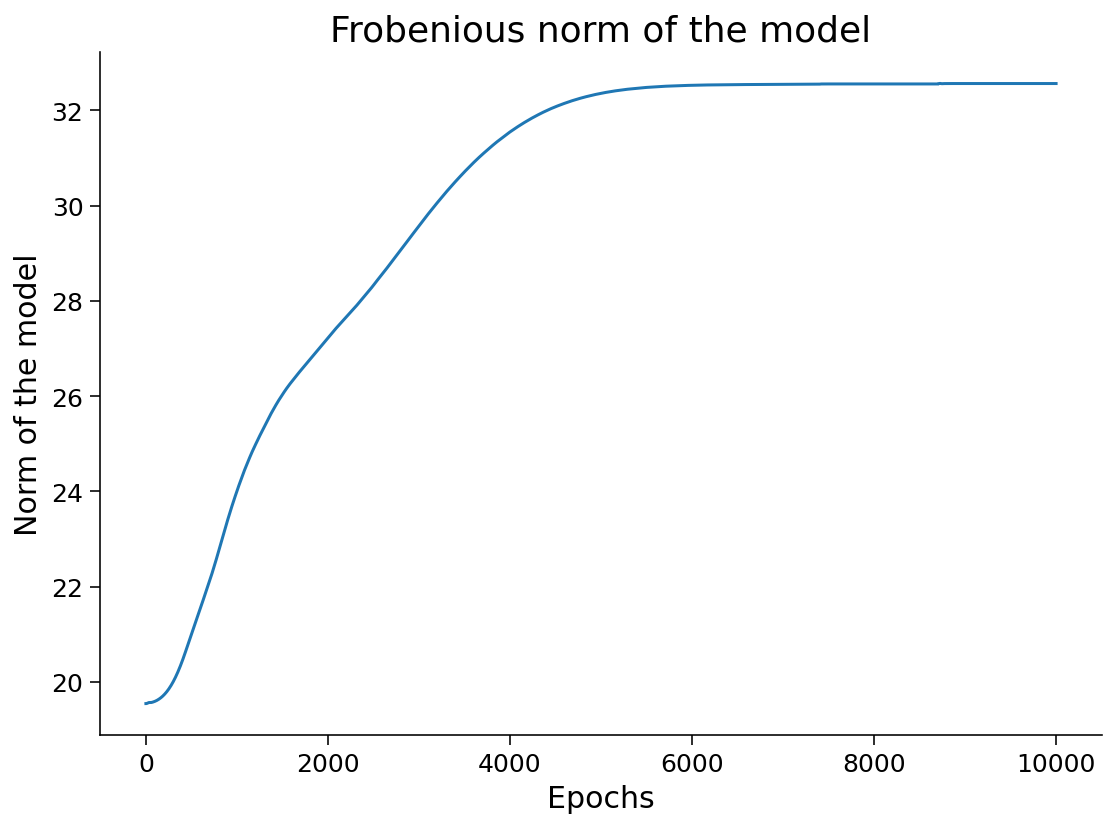

In [27]:
# @markdown Frobenious norm of the model
plt.figure(figsize=(8, 6))
plt.plot(model_norm)
plt.ylabel('Norm of the model')
plt.xlabel('Epochs')
plt.title('Frobenious norm of the model')
plt.show()

Finally, you can compare the Frobenius norm per layer in the model, before and after training.

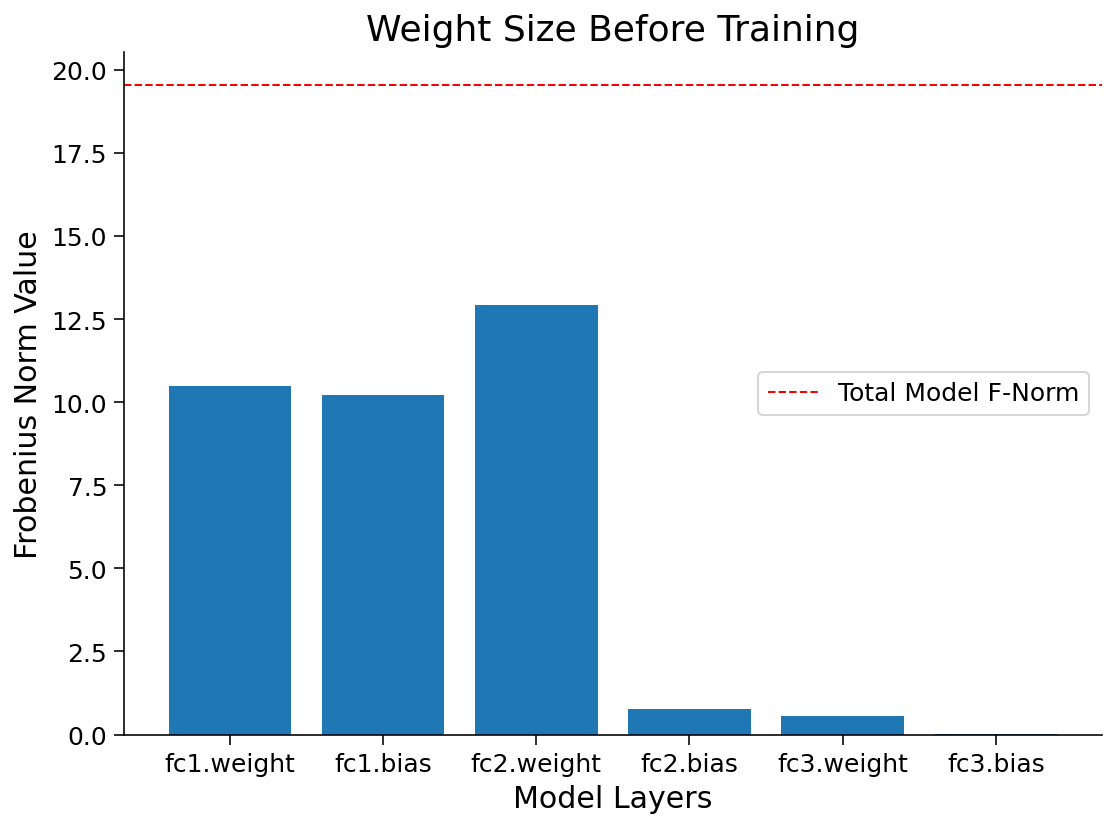

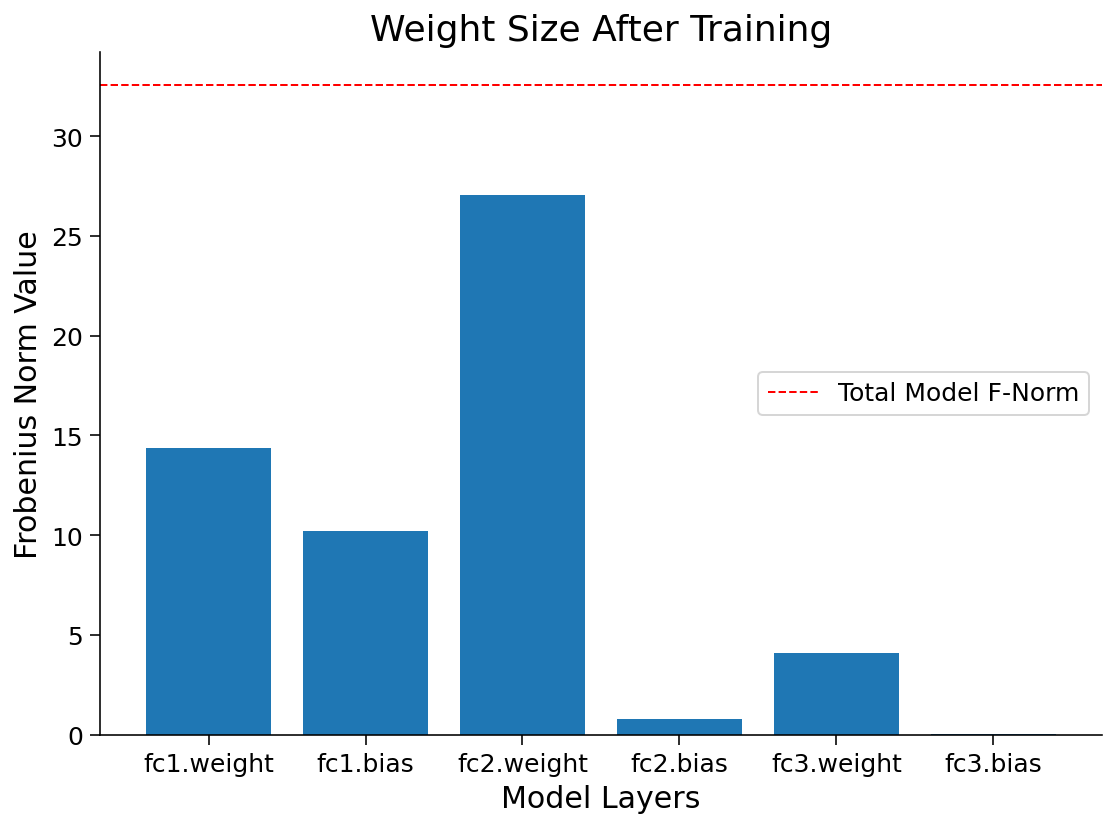

In [28]:
# @markdown Frobenius norm per layer before and after training
normf, wsf, label = calculate_frobenius_norm(model)

plot_weights(float(normi), label, wsi,
             title='Weight Size Before Training')
plot_weights(float(normf), label, wsf,
             title='Weight Size After Training')

## Section 2.2: Overfitting on Test Dataset

In principle, we should not touch our test set until choosing all our hyperparameters. Were we to use the test data in the model selection process, there is a risk that we might overfit the test data, and then we will be in serious trouble. If we overfit our training data, there is always an evaluation using the test data to keep us honest. But if we overfit the test data, how would we ever know?

Note that there is another kind of overfitting: you do "honest" fitting on one set of images or posts or medical records, but it may not generalize to other images, posts, or medical records.

### Validation Dataset

A common practice to address this problem is to split our data in three ways, using a validation dataset (or validation set) to tune the hyperparameters. Ideally, we would only touch the test data once, to assess the very best model or to compare a small number of models to each other, real-world test data is seldom discarded after just one use.

---
# Section 3: Memorization

*Time estimate: ~20 mins*


Given sufficiently large networks and enough training, Neural Networks can achieve almost 100% train accuracy by remembering each training example. However, this is bad because it will mean that the model will fail when presented with new data.

In this section, we train three MLPs; one each on:

1. Animal Faces Dataset
2. A Completely Noisy Dataset (Random shuffling of all labels)
3. A partially Noisy Dataset (Random shuffling of 15% labels)

Now, think for a couple of minutes as to what the train and test accuracies of each of these models might be, given that you train for sufficient time and use a powerful network.

First, let's create the required dataloaders for all three datasets. Notice how we split the data. We train on a fraction of the dataset as it will be faster to train and will overfit more clearly.

In [29]:
# Dataloaders for the Dataset
batch_size = 128
classes = ('cat', 'dog', 'wild')

# Defining number of examples for train, val test
len_train, len_val, len_test = 100, 100, 14430

train_transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])
data_path = pathlib.Path('.')/'afhq'  # Using pathlib to be compatible with all OS's
img_dataset = ImageFolder(data_path/'train', transform=train_transform)

In [30]:
# Dataloaders for the Original Dataset

# For reproducibility
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

img_train_data, img_val_data,_ = torch.utils.data.random_split(img_dataset,
                                                               [len_train,
                                                                len_val,
                                                                len_test])

# Creating train_loader and Val_loader
train_loader = torch.utils.data.DataLoader(img_train_data,
                                           batch_size=batch_size,
                                           num_workers=2,
                                           worker_init_fn=seed_worker,
                                           generator=g_seed)

val_loader = torch.utils.data.DataLoader(img_val_data,
                                         batch_size=1000,
                                         num_workers=2,
                                         worker_init_fn=seed_worker,
                                         generator=g_seed)

In [31]:
# Dataloaders for the Random Dataset

# For reproducibility
g_seed = torch.Generator()
g_seed.manual_seed(SEED + 1)

# Splitting randomized data into training and validation data
data_path = pathlib.Path('.')/'afhq_random_32x32/afhq_random' # Using pathlib to be compatible with all OS's
img_dataset = ImageFolder(data_path/'train', transform=train_transform)
random_img_train_data, random_img_val_data,_ = torch.utils.data.random_split(img_dataset, [len_train, len_val, len_test])

# Randomized train and validation dataloader
rand_train_loader = torch.utils.data.DataLoader(random_img_train_data,
                                                batch_size=batch_size,
                                                num_workers=2,
                                                worker_init_fn=seed_worker,
                                                generator=g_seed)

rand_val_loader = torch.utils.data.DataLoader(random_img_val_data,
                                              batch_size=1000,
                                              num_workers=2,
                                              worker_init_fn=seed_worker,
                                              generator=g_seed)

In [32]:
# Dataloaders for the Partially Random Dataset

# For reproducibility
g_seed = torch.Generator()
g_seed.manual_seed(SEED + 1)

# Splitting data between training and validation dataset for partially randomized data
data_path = pathlib.Path('.')/'afhq_10_32x32/afhq_10' # Using pathlib to be compatible with all OS's
img_dataset = ImageFolder(data_path/'train', transform=train_transform)
partially_random_train_data, partially_random_val_data,_ = torch.utils.data.random_split(img_dataset, [len_train, len_val, len_test])

# Training and Validation loader for partially randomized data
partial_rand_train_loader = torch.utils.data.DataLoader(partially_random_train_data,
                                                        batch_size=batch_size,
                                                        num_workers=2,
                                                        worker_init_fn=seed_worker,
                                                        generator=g_seed)

partial_rand_val_loader = torch.utils.data.DataLoader(partially_random_val_data,
                                                      batch_size=1000,
                                                      num_workers=2,
                                                      worker_init_fn=seed_worker,
                                                      generator=g_seed)

Now let's define a model which has many parameters compared to the training dataset size, and train it on these datasets.

In [33]:
class BigAnimalNet(nn.Module):
  """
  Network Class - Animal Faces with following structure:
  nn.Linear(3*32*32, 124) + leaky_relu(self.fc1(x)) # First fully connected layer
  nn.Linear(124, 64) + leaky_relu(self.fc2(x)) # Second fully connected layer
  nn.Linear(64, 3) # Final fully connected layer
  """

  def __init__(self):
    """
    Initialize parameters for BigAnimalNet

    Args:
      None

    Returns:
      Nothing
    """
    super(BigAnimalNet, self).__init__()
    self.fc1 = nn.Linear(3*32*32, 124)
    self.fc2 = nn.Linear(124, 64)
    self.fc3 = nn.Linear(64, 3)

  def forward(self, x):
    """
    Forward pass of BigAnimalNet

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Output/Predictions
    """
    x = x.view(x.shape[0], -1)
    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x))
    x = self.fc3(x)
    output = F.log_softmax(x, dim=1)
    return output

Before training our `BigAnimalNet()`, calculate the Frobenius norm again.

In [34]:
set_seed(seed=SEED)
normi, wsi, label = calculate_frobenius_norm(BigAnimalNet())

Random seed 2021 has been set.


Now, train our `BigAnimalNet()` model

Random seed 2021 has been set.


  0%|          | 0/200 [00:00<?, ?it/s]

Time to memorize the dataset: 97.34003281593323


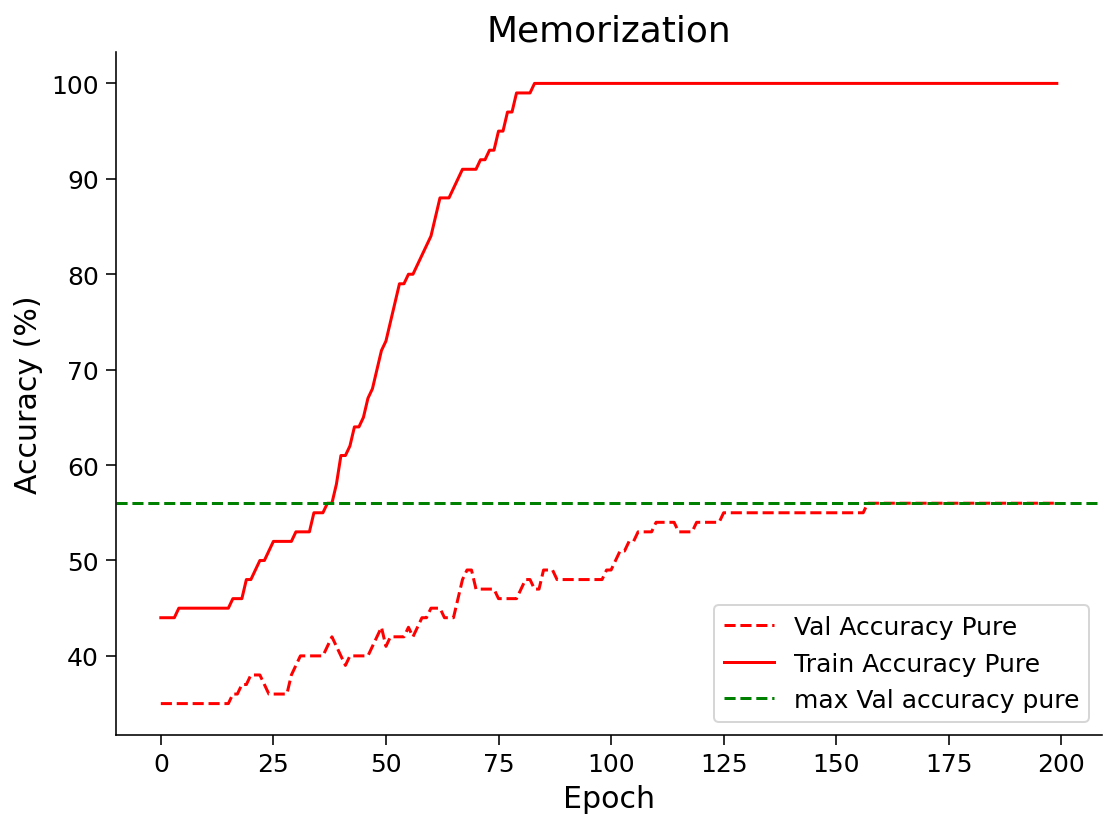

In [35]:
# Here we have 100 true train data.

# Set the arguments
args = {
    'epochs': 200,
    'lr': 5e-3,
    'momentum': 0.9,
    'device': DEVICE
}


# Initialize the network
set_seed(seed=SEED)
model = BigAnimalNet()

start_time = time.time()

# Train the network
val_acc_pure, train_acc_pure, _, model = main(args=args,
                                              model=model,
                                              train_loader=train_loader,
                                              val_loader=val_loader)
end_time = time.time()

print(f"Time to memorize the dataset: {end_time - start_time}")

# Train and Test accuracy plot
plt.figure(figsize=(8, 6))
plt.plot(val_acc_pure, label='Val Accuracy Pure', c='red', ls='dashed')
plt.plot(train_acc_pure, label='Train Accuracy Pure', c='red', ls='solid')
plt.axhline(y=max(val_acc_pure), c='green', ls='dashed',
            label='max Val accuracy pure')
plt.title('Memorization')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

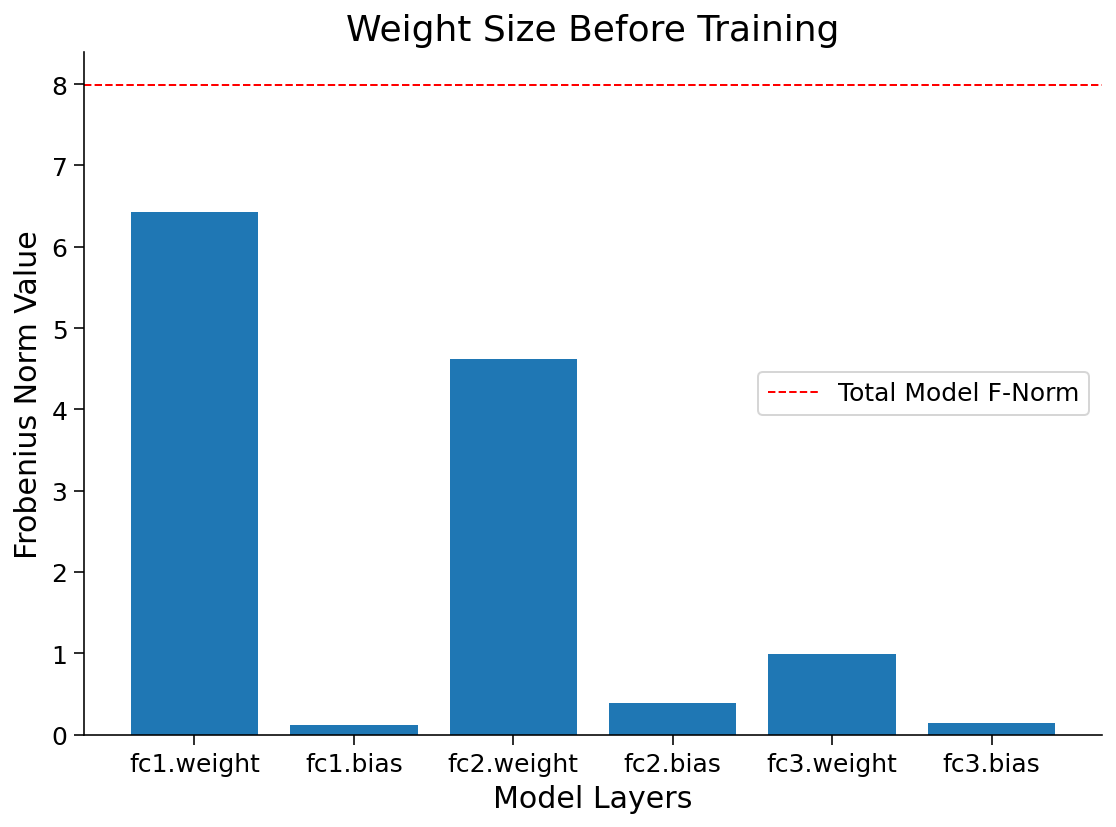

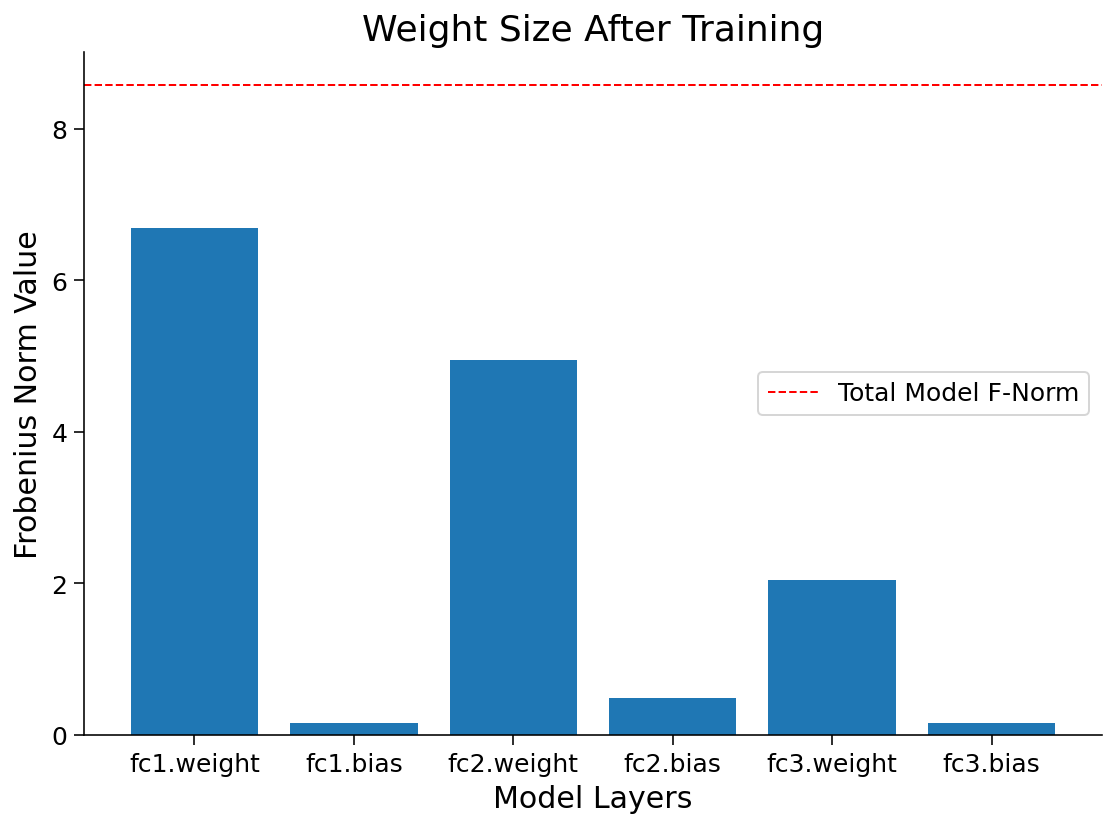

In [36]:
# @markdown #### Frobenius norm for AnimalNet before and after training
normf, wsf, label = calculate_frobenius_norm(model)

plot_weights(float(normi), label, wsi, title='Weight Size Before Training')
plot_weights(float(normf), label, wsf, title='Weight Size After Training')

## Data Visualizer

Before we train the model on data with random labels, let's visualize and verify for ourselves that the data is random. Here, we have:
```python
classes = ("cat", "dog", "wild")
``` 
We use the `.permute()` method. `plt.imshow()` expects the input to be in NumPy format and in the format $(P_x, P_y, 3)$, where $P_x$ and $P_y$ are the number of pixels along $x$ and $y$ axis, respectively.

The image belongs to : cat


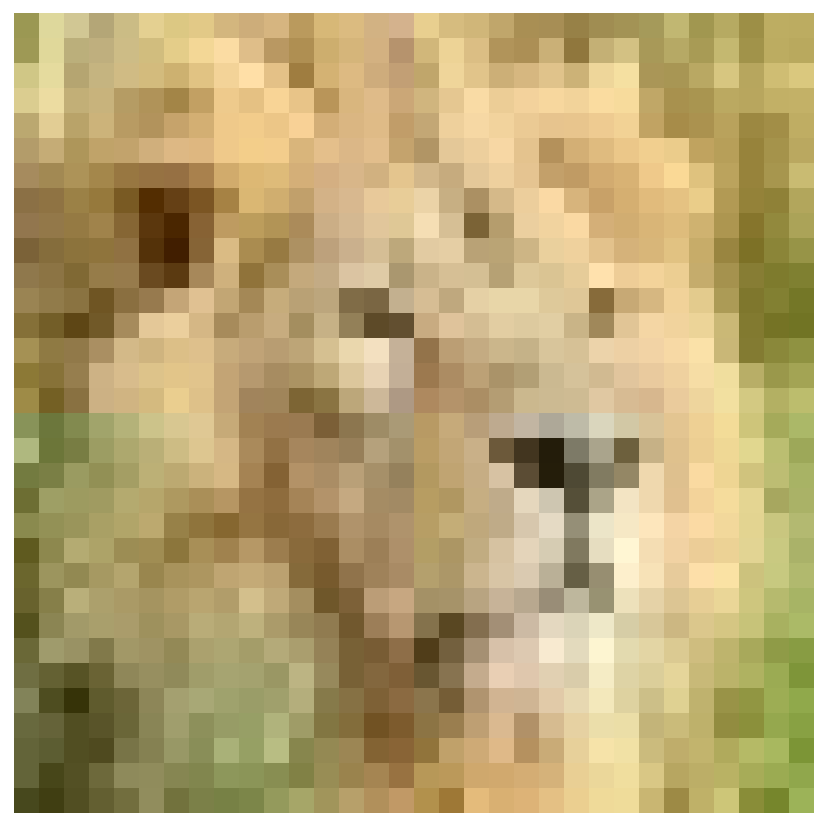

In [37]:
def visualize_data(dataloader):
  """
  Helper function to visualize data

  Args:
    dataloader: torch.tensor
      Dataloader to visualize

  Returns:
    Nothing
  """

  for idx, (data, label) in enumerate(dataloader):
    plt.figure(idx)

    # Choose the datapoint you would like to visualize
    index = 22

    # Choose that datapoint using index and permute the dimensions
    # and bring the pixel values between [0, 1]
    data = data[index].permute(1, 2, 0) * \
           torch.tensor([0.5, 0.5, 0.5]) + \
           torch.tensor([0.5, 0.5, 0.5])

    # Convert the torch tensor into numpy
    data = data.numpy()

    plt.imshow(data)
    plt.axis(False)
    image_class = classes[label[index].item()]
    print(f'The image belongs to : {image_class}')

  plt.show()


# Call the function
visualize_data(rand_train_loader)

 Now let's train the network on the shuffled data and see if it memorizes.

Random seed 2021 has been set.


  0%|          | 0/200 [00:00<?, ?it/s]

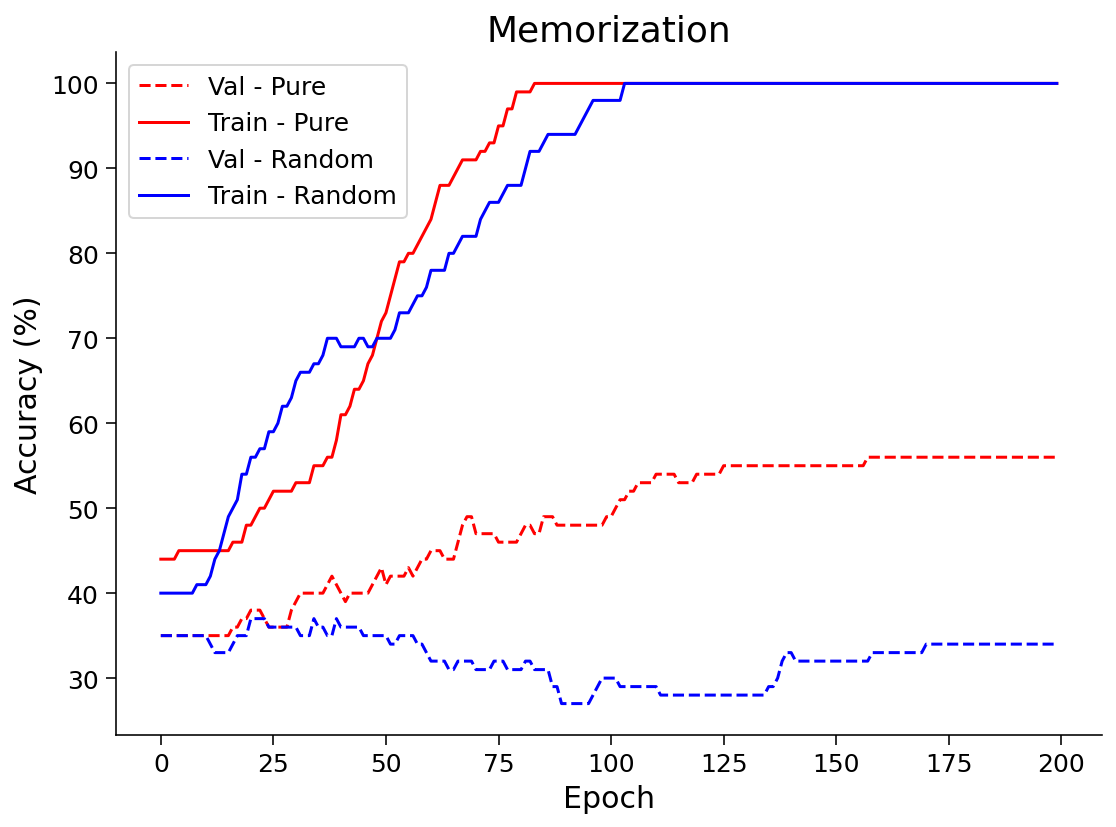

In [38]:
# Here we have 100 completely shuffled train data.

# Set the arguments
args = {
    'epochs': 200,
    'lr': 5e-3,
    'momentum': 0.9,
    'device': DEVICE
}

# Initialize the model
set_seed(seed=SEED)
model = BigAnimalNet()

# Train the model
val_acc_random, train_acc_random, _, model = main(args,
                                                  model,
                                                  rand_train_loader,
                                                  val_loader)

# Train and Test accuracy plot
plt.figure(figsize=(8, 6))
plt.plot(val_acc_pure,label='Val - Pure',c='red',ls = 'dashed')
plt.plot(train_acc_pure,label='Train - Pure',c='red',ls = 'solid')
plt.plot(val_acc_random,label='Val - Random',c='blue',ls = 'dashed')
plt.plot(train_acc_random,label='Train - Random',c='blue',ls = 'solid')

plt.title('Memorization')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Isn't it surprising to see that the ANN was able to achieve 100% training accuracy on randomly shuffled labels? This is one of the reasons why training accuracy is not a good indicator of model performance.

---
# Section 4: Early Stopping

*Time estimate: ~20 mins*

In [ ]:
# @title Video 4: Early Stopping
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1cB4y1K777", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"72IG2bX5l30", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# Add event to airtable
atform.add_event('Video 4: Early Stopping')

display(out)

Now that we have established that the validation accuracy reaches the peak well before the model overfits, we want to stop the training somehow early. You should have also observed from the above plots that the train/test loss on real data is not very smooth, and hence you might guess that the choice of the epoch can play a crucial role in the validation/test accuracy. 

Early stopping stops training when the validation accuracies stop increasing.

<br>

<center><img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/static/early-stopping-machine-learning-5422207.jpg" alt="Overfitting" width="600"/></center>

## Coding Exercise 4: Early Stopping

Reimplement the main function to include early stopping as described above. Then run the code below to validate your implementation.

Random seed 2021 has been set.


  0%|          | 0/200 [00:00<?, ?it/s]

Early stopped on epoch: 66
Maximum Validation Accuracy is reached at epoch: 45


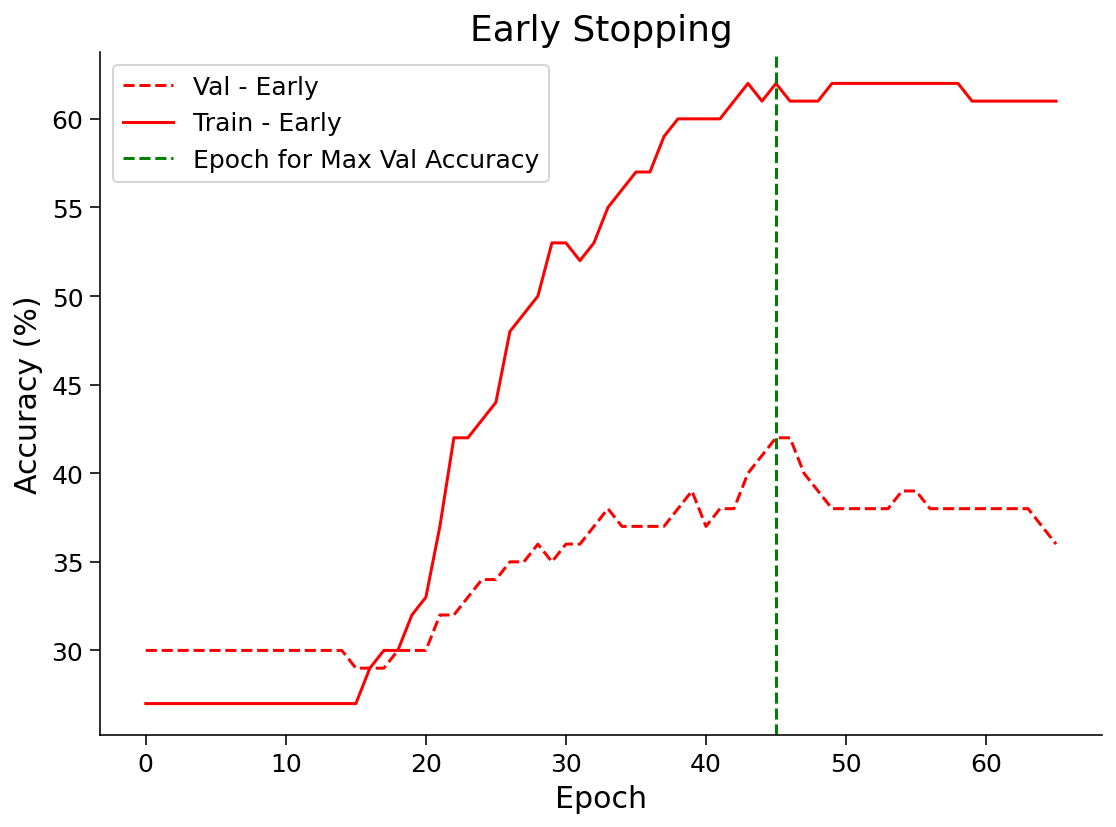

In [51]:
def early_stopping_main(args, model, train_loader, val_loader):
  """
  Function to simulate early stopping

  Args:
    args: dictionary
      Dictionary with epochs: 200, lr: 5e-3, momentum: 0.9, device: DEVICE
    model: nn.module
      Neural network instance
    train_loader: torch.loader
      Train dataset
    val_loader: torch.loader
      Validation set

  Returns:
    val_acc_list: list
      Val accuracy log until early stop point
    train_acc_list: list
      Training accuracy log until early stop point
    best_model: nn.module
      Model performing best with early stopping
    best_epoch: int
      Epoch at which early stopping occurs
  """

  ####################################################################
  # Fill in all missing code below (...),
  # then remove or comment the line below to test your function
  # raise NotImplementedError("Complete the early_stopping_main function")
  ####################################################################
  device = args['device']
  model = model.to(device)
  optimizer = optim.SGD(model.parameters(),
                        lr=args['lr'],
                        momentum=args['momentum'])

  best_acc = 0.0
  best_epoch = 0

  # Number of successive epochs that you want to wait before stopping training process
  patience = 20

  # Keeps track of number of epochs during which the val_acc was less than best_acc
  wait = 0

  val_acc_list, train_acc_list = [], []
  for epoch in tqdm(range(args['epochs'])):

    # Train the model
    trained_model = train(args, model, train_loader, optimizer)
    # print(trained_model)
    
    # Calculate training accuracy
    train_acc = test(trained_model, train_loader, device=device )

    # Calculate validation accuracy
    val_acc = test(trained_model, val_loader, device=device )

    if (val_acc > best_acc):
      best_acc = val_acc
      best_epoch = epoch
      best_model = copy.deepcopy(trained_model)
      wait = 0
    else:
      wait += 1

    if (wait > patience):
      print(f'Early stopped on epoch: {epoch}')
      break

    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

  return val_acc_list, train_acc_list, best_model, best_epoch


# Add event to airtable
atform.add_event('Coding Exercise 4: Early Stopping')

# Set the arguments
args = {
    'epochs': 200,
    'lr': 5e-4,
    'momentum': 0.99,
    'device': DEVICE
}

# Initialize the model
set_seed(seed=SEED)
model = AnimalNet()

## Uncomment to test
val_acc_earlystop, train_acc_earlystop, best_model, best_epoch = early_stopping_main(args, model, train_loader, val_loader)
print(f'Maximum Validation Accuracy is reached at epoch: {best_epoch:2d}')
early_stop_plot(train_acc_earlystop, val_acc_earlystop, best_epoch)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W2D1_Regularization/solutions/W2D1_Tutorial1_Solution_284ce9c0.py)

*Example output:*

<img alt='Solution hint' align='left' width=1120.0 height=832.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D1_Regularization/static/W2D1_Tutorial1_Solution_284ce9c0_3.png>



## Think! 4: Early Stopping

Discuss among your pod why or why not:
* Do you think early stopping can be harmful to training your network?

In [52]:
# @title Student Response
from ipywidgets import widgets


text=widgets.Textarea(
   value='Type your answer here and click on `Submit!`',
   placeholder='Type something',
   description='',
   disabled=False
)

button = widgets.Button(description="Submit!")

display(text,button)

def on_button_clicked(b):
   atform.add_answer('q2', text.value)
   print("Submission successful!")


button.on_click(on_button_clicked)

Textarea(value='Type your answer here and click on `Submit!`', placeholder='Type something')

Button(description='Submit!', style=ButtonStyle())

Submission successful!


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W2D1_Regularization/solutions/W2D1_Tutorial1_Solution_1329e07b.py)



---
# Summary

In this tutorial, you have been introduced to the regularization technique, described as shrinkage. We have learned about overfitting, one of the worst caveats in deep learning, and finally, we have learned a method of reducing overfitting in our models called early-stopping.

If you have time left, you can learn how a model behaves when is trained with randomized labels.

In [53]:
# @title Airtable Submission Link
from IPython import display as IPydisplay
IPydisplay.HTML(
   f"""
 <div>
   <a href= "{atform.url()}" target="_blank">
   <img src="https://github.com/NeuromatchAcademy/course-content-dl/blob/main/tutorials/static/AirtableSubmissionButton.png?raw=1"
 alt="button link to Airtable" style="width:410px"></a>
   </div>""" )

---
# Bonus: Train with randomized labels

In this part, let's train on a partially shuffled dataset where 15% of the labels are noisy.

In [ ]:
# Here we have 15% partially shuffled train data.

# Set the arguments
args = {
    'epochs': 200,
    'lr': 5e-3,
    'momentum': 0.9,
    'device': DEVICE
}

# Intialize the model
set_seed(seed=SEED)
model = BigAnimalNet()

# Train the model
val_acc_shuffle, train_acc_shuffle, _, _, = main(args,
                                                 model,
                                                 partial_rand_train_loader,
                                                 val_loader)

# Train and test acc plot
plt.figure(figsize=(8, 6))
plt.plot(val_acc_shuffle, label='Val Accuracy shuffle', c='red', ls='dashed')
plt.plot(train_acc_shuffle, label='Train Accuracy shuffle', c='red', ls='solid')
plt.axhline(y=max(val_acc_shuffle), c='green', ls='dashed',
            label='Max Val Accuracy shuffle')
plt.title('Memorization')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
#@markdown #### Plotting them all together (Run Me!)
plt.figure(figsize=(8, 6))
plt.plot(val_acc_pure,label='Val - Pure',c='red',ls = 'dashed')
plt.plot(train_acc_pure,label='Train - Pure',c='red',ls = 'solid')
plt.plot(val_acc_random,label='Val - Random',c='blue',ls = 'dashed')
plt.plot(train_acc_random,label='Train - Random',c='blue',ls = 'solid')
plt.plot(val_acc_shuffle, label='Val - shuffle', c='y', ls='dashed')
plt.plot(train_acc_shuffle, label='Train - shuffle', c='y', ls='solid')

plt.title('Memorization')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Think! Bonus: Does it Generalize?

Given that the Neural Network fit/memorize the training data perfectly:

* Do you think it generalizes well?
* What makes you think it does or doesn't?

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W2D1_Regularization/solutions/W2D1_Tutorial1_Solution_566afa93.py)



Also, it is interesting to note that sometimes the model trained on slightly shuffled data does slightly better than the one trained on pure data. Shuffling some of the data is a form of regularization, i.e., one of many ways of adding noise to the training data.